In [1]:
import numpy as np
import os
import glob
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2 as cv
import time

/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from chainercv.visualizations import vis_bbox
from chainercv.utils import read_image

In [3]:
# This is needed to display the images.
%matplotlib inline

In [4]:
PATH_TO_IMAGES = './images/ssd_resized/'
MODEL_PATH = './models/ssd/fold4/'
PATH_TO_CKPT = os.path.join(MODEL_PATH, 'frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(MODEL_PATH, 'label_map.pbtxt')

NUM_CLASSES = 6
IMAGE_SIZE = (12, 8)

In [5]:
# load frozen model
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
# test reseized images
test_images = glob.glob(PATH_TO_IMAGES + '*.JPG')
N = len(test_images)
Wr, Hr = 300, 225
W, H = 3648, 2736

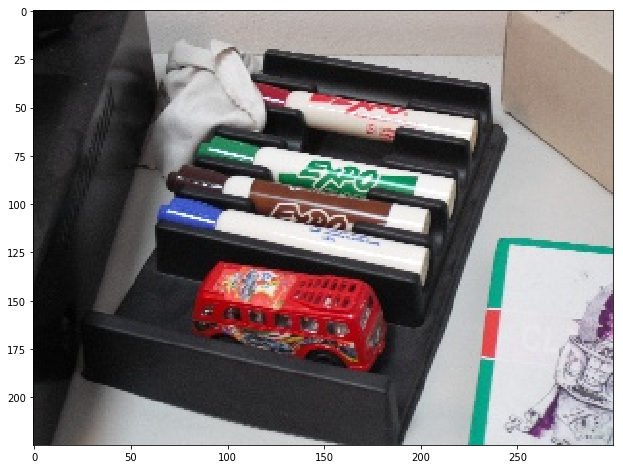

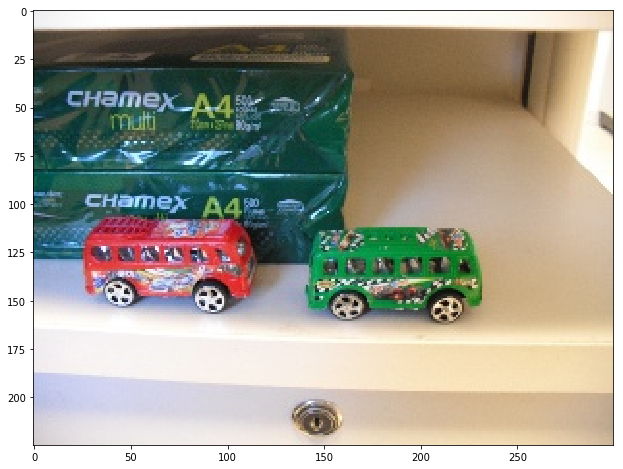

In [7]:
input_images = []
print_only = 2
for path in test_images:
    image = cv.imread(path)
    image = cv.resize(image, (Wr, Hr), interpolation=cv.INTER_AREA)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    input_images.append(image)
    
    if print_only:
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image)
        print_only -= 1

In [8]:
with detection_graph.as_default():
    with tf.Session() as sess:
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
        
        tic = time.time()
        outputs = sess.run(tensor_dict, feed_dict={image_tensor: input_images})
        toc = time.time()

In [9]:
print('It took only {:.2f}[sec] to infer {} images!'.format(toc-tic, N))

It took only 4.34[sec] to infer 60 images!


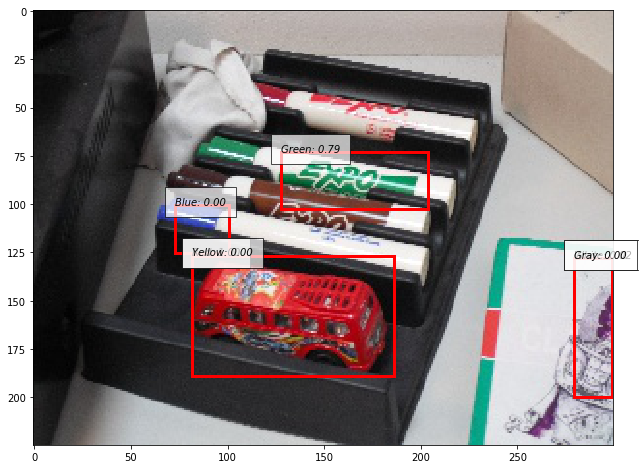

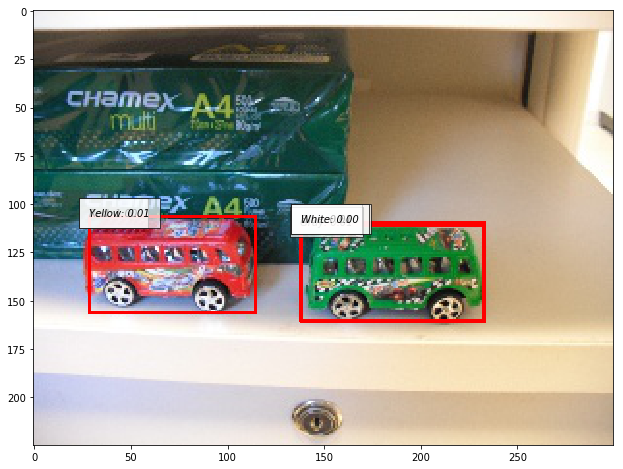

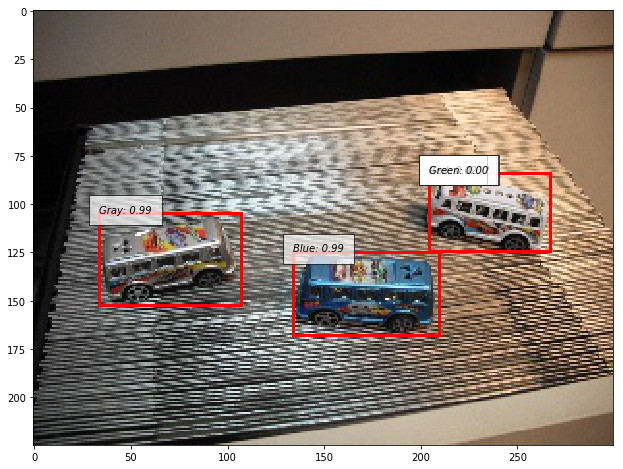

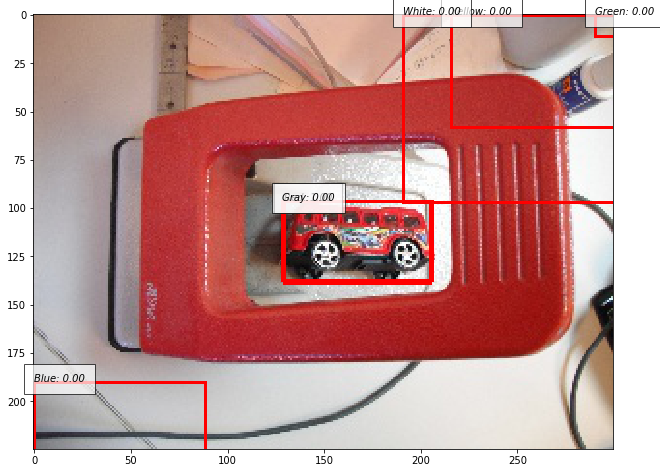

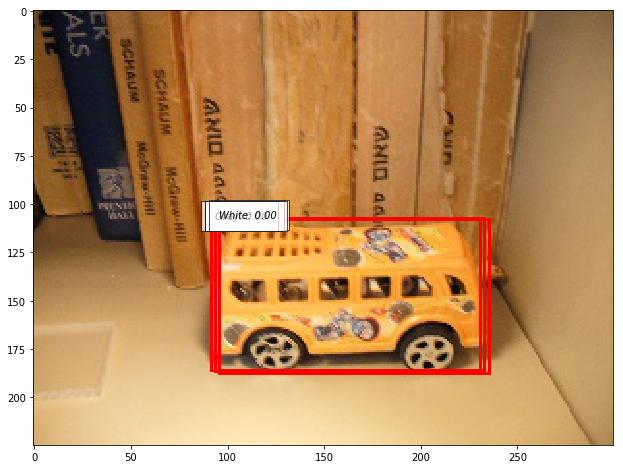

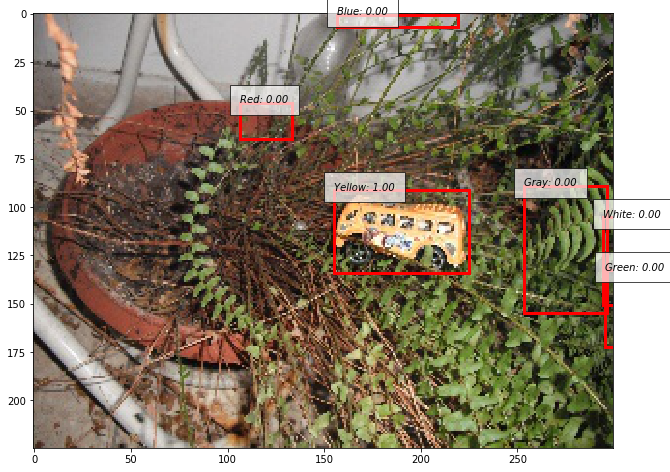

In [10]:
label_names = ['Green', 'Yellow', 'White', 'Gray', 'Blue', 'Red']
print_only = 5
for i in range(N):
    img = read_image(test_images[i])
    bbox = np.multiply(outputs['detection_boxes'][i], [Hr, Wr, Hr, Wr])
    fig = plt.figure(figsize=IMAGE_SIZE)
    ax1 = fig.add_subplot(1, 1, 1)
    vis_bbox(img, bbox=bbox, label=outputs['detection_classes'][i].astype(int)-1,
             label_names=label_names, score=outputs['detection_scores'][i], ax=ax1)
    plt.show()
    
    if print_only:
        print_only -=1
    else:
        break

In [11]:
# create annotation file in the define format
anno_file = open('annotationsTest.txt', 'w')

# parse each detection to a line and write to file
for i, (det_score, det_cls, det_box, img_path) in enumerate(zip(outputs['detection_scores'], outputs['detection_classes'],
                                                              outputs['detection_boxes'], test_images)):
    # define object score threshold
    obj_indices = np.where(det_score > 0.1)
    # if there is no score that passes the th pick the max
    if not obj_indices[0].size:
        obj_indices = [np.argmax(det_score)]
    # pickup winner classes
    winner_classes = det_cls[obj_indices].astype(int)
    # pickup winner classes' bboxes
    winner_boxes = np.rint(np.multiply(det_box, [H, W, H, W])[obj_indices]).astype(int)
    filename = img_path[img_path.rfind('_')+1:]
    line = '{}:'.format(filename)
    for c, b in zip(winner_classes, winner_boxes):
        line = line + '[{},{},{},{},{}],'.format(b[1], b[0], b[3]-b[1], b[2]-b[0], c)
    line = line[:-1] + '\n'
    anno_file.write(line)

anno_file.close()